In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics
from matplotlib import ticker

In [2]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("max_columns", 100)

In [3]:
combined = pd.read_csv("data/combined1.csv")

In [4]:
from imblearn import under_sampling
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from collections import Counter

In [5]:
oversample = SMOTE()

In [6]:
y = combined['callback']
X = combined.drop(['callback'], axis=1)


In [7]:
X, y = oversample.fit_resample(X,y)

In [8]:
counter = Counter(y)
for k, v in counter.items():
    dist = v / len(y) * 100
    print(f"Class = {k}, n ={v} ({dist}%)")

Class = 0.0, n =11612 (50.0%)
Class = 1.0, n =11612 (50.0%)


## Preprocessing Data - Combined Data ##

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [10]:
kfold = KFold(n_splits=5)
skfold = StratifiedKFold(n_splits=5, shuffle=True)
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

In [11]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Testing Data  - Penalized Logistic Regression ##

In [12]:
from sklearn.linear_model import LogisticRegression
logreg_scaled = LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear').fit(X_train_scaled, y_train)

print("PENALIZED LOGISTIC REGRESSION (SCALED DATA)")
print("Training set score: {:.2f}".format(logreg_scaled.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(logreg_scaled.score(X_test_scaled, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(logreg_scaled, 
                                                                             X_train_scaled, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))


logreg_scaled_coef = pd.DataFrame(data=logreg_scaled.coef_, 
                                  columns=X.columns, 
                                  index=['Penalized Scaled Logistic Regression Coefficients'])

yhat = logreg_scaled.predict(X_test_scaled)
c2 = [logreg_scaled_coef]
coefs = pd.concat(c2)
coefs.T.sort_values(by = 'Penalized Scaled Logistic Regression Coefficients', ascending=False)

PENALIZED LOGISTIC REGRESSION (SCALED DATA)
Training set score: 0.65
Test set score: 0.65


/Users/andrewlai/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Mean Cross Validation, SKFold: 0.65


,Penalized Scaled Logistic Regression Coefficients
skillspeaking,0.129590
female,0.105006
language_skills,0.003608
skillsocialper,0.003121
accreditation,-0.173367
reference,-0.229347
anglo,-0.851797
east_asian,-1.037118
south_asian,-1.082240
montreal,-3.158129


<AxesSubplot:title={'center':'Feature Importance (Logistic Regression)'}>

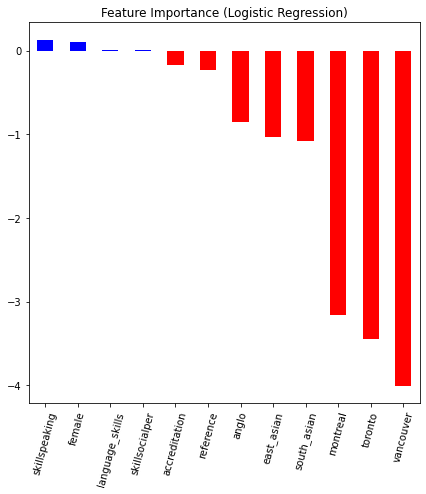

In [13]:
graph = coefs.T.sort_values(by = 'Penalized Scaled Logistic Regression Coefficients', ascending=False)
graph['Penalized Scaled Logistic Regression Coefficients'].plot.bar(
    title = 'Feature Importance (Logistic Regression)',
    legend = False, 
    figsize = (7,7),
    rot = 75,
    color=(graph['Penalized Scaled Logistic Regression Coefficients'] > 0).map({True: 'b', False: 'red'}))

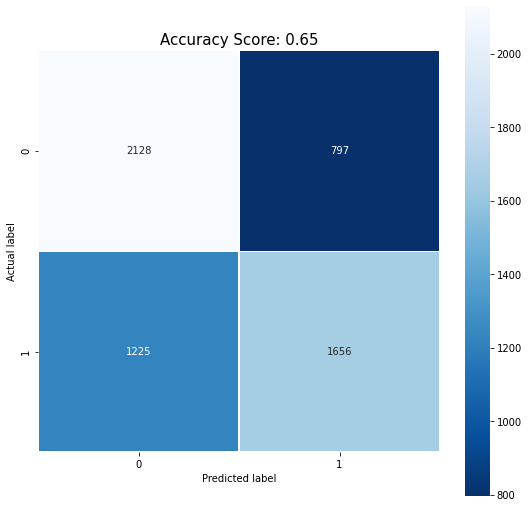

In [14]:
cm = metrics.confusion_matrix(y_test, yhat)
plt.figure(figsize=(9,9))
score = (logreg_scaled.score(X_test_scaled, y_test))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);

In [15]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, yhat, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.63      0.73      0.68      2925
     class 1       0.68      0.57      0.62      2881

    accuracy                           0.65      5806
   macro avg       0.65      0.65      0.65      5806
weighted avg       0.65      0.65      0.65      5806



## Testing Data - Random Forest  ##

In [16]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=200)
rforest.fit(X_train_scaled,y_train)
ypred = rforest.predict(X_test_scaled)

In [17]:
print("RANDOM FORESST (SCALED DATA)")
print("Training set score: {:.2f}".format(rforest.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(rforest.score(X_test_scaled, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(rforest, 
                                                                             X_train_scaled, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))

rforest_feature = pd.DataFrame(data=rforest.feature_importances_).T
rforest_feature.columns = X.columns
rforest_feature.index=['Random Forest Features']


rforest_feature.T.sort_values(by = 'Random Forest Features', ascending=False)

RANDOM FORESST (SCALED DATA)
Training set score: 0.85
Test set score: 0.83
Mean Cross Validation, SKFold: 0.82


,Random Forest Features
skillspeaking,0.227326
skillsocialper,0.196114
female,0.157061
language_skills,0.130449
toronto,0.054961
east_asian,0.046727
vancouver,0.043869
south_asian,0.043669
montreal,0.038821
anglo,0.038432


<AxesSubplot:title={'center':'Feature Importance (Random Forest)'}>

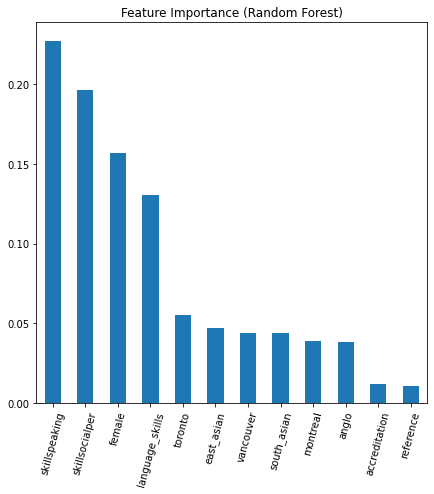

In [18]:
rf_graph = rforest_feature.T.sort_values(by = 'Random Forest Features', ascending=False)
rf_graph['Random Forest Features'].plot.bar(
    title = 'Feature Importance (Random Forest)',
    legend = False, 
    figsize = (7,7),
    rot = 75)

In [19]:
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83      2830
         1.0       0.84      0.82      0.83      2976

    accuracy                           0.83      5806
   macro avg       0.83      0.83      0.83      5806
weighted avg       0.83      0.83      0.83      5806



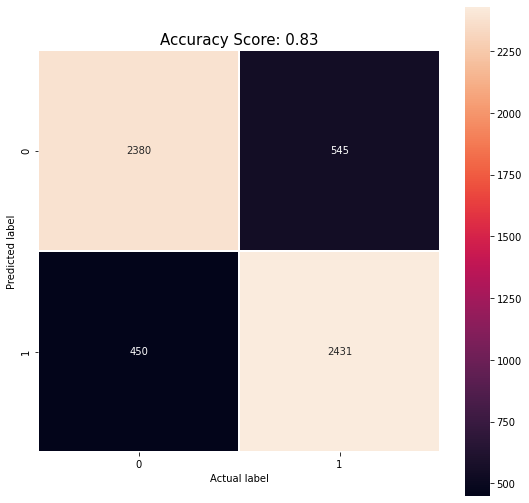

In [21]:
rf_mat = metrics.confusion_matrix(y_test, ypred)
plt.figure(figsize=(9,9))
score = (rforest.score(X_test_scaled, y_test))
sns.heatmap(rf_mat, annot=True, fmt=".0f", linewidths=.5, square = True);
plt.xlabel('Actual label');
plt.ylabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);

## Testing - Random Forest (Grid Search) ##

In [27]:
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

In [28]:
CV_rfc = GridSearchCV(estimator=rforest, param_grid=param_grid, cv= skfold)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=200),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500]})

In [125]:
X_test = X_test.to_numpy()
X_train = X_train.to_numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [29]:
print("Best Parameter: {}".format(CV_rfc.best_params_))

Best Parameter: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 500}


In [94]:
rforest_grid =  RandomForestClassifier(n_estimators=500, max_features = 'sqrt', criterion= 'entropy')
rforest_grid.fit(X_train,y_train)
ypred = rforest_grid.predict(X_test)

In [115]:
print("RANDOM FORESST (SCALED DATA) Grid Search")
print("Training set score: {:.2f}".format(rforest_grid.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rforest_grid.score(X_test, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(rforest_grid, 
                                                                             X_train, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))

rforest_feature = pd.DataFrame(data=rforest_grid.feature_importances_).T
rforest_feature.columns = X.columns
rforest_feature.index=['Random Forest Features']

RANDOM FORESST (SCALED DATA) Grid Search
Training set score: 0.85
Test set score: 0.83
Mean Cross Validation, SKFold: 0.82


In [116]:
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83      2828
         1.0       0.85      0.82      0.83      2978

    accuracy                           0.83      5806
   macro avg       0.83      0.83      0.83      5806
weighted avg       0.83      0.83      0.83      5806



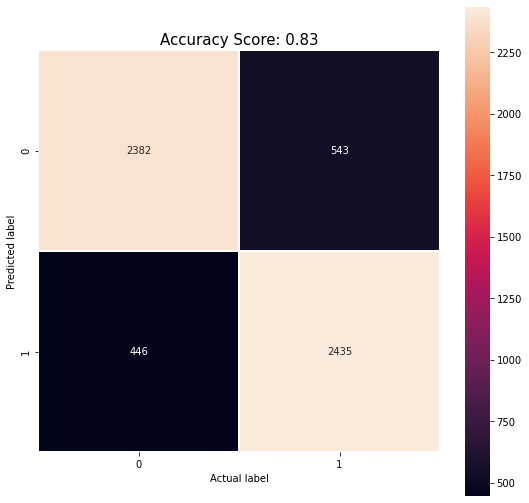

In [117]:
rf_mat = metrics.confusion_matrix(y_test, ypred)
plt.figure(figsize=(9,9))
score = (rforest_grid.score(X_test, y_test))
sns.heatmap(rf_mat, annot=True, fmt=".0f", linewidths=.5, square = True);
plt.xlabel('Actual label');
plt.ylabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);

In [118]:
from sklearn.metrics import accuracy_score

print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,ypred))

Accuracy for Random Forest on CV data:  0.8296589734757148


In [85]:
print(combined.columns)
combined['montreal'].value_counts()

Index(['language_skills', 'accreditation', 'reference', 'female', 'callback',
       'skillspeaking', 'skillsocialper', 'east_asian', 'south_asian', 'anglo',
       'vancouver', 'toronto', 'montreal'],
      dtype='object')


0    10609
1     2284
Name: montreal, dtype: int64

In [229]:
X_check = np.array([[1, 0, 1, 0, 59.124, 62.3134, 1, 1, 1, 1, 1, 0]])
X_check[:, 4] = X_check[:, 4].astype(float)
X_check[:, 5] = X_check[:, 5].astype(float)
X_check[:, 0:3] = X_check[:, 0:3].astype(int)
X_check[:, 6:11] = X_check[:, 6:11].astype(int)

In [230]:
X_check

array([[ 1.    ,  0.    ,  1.    ,  0.    , 59.124 , 62.3134,  1.    ,
         1.    ,  1.    ,  1.    ,  1.    ,  0.    ]])

In [232]:
y_check = rforest_grid.predict(X_check)
print(y_check)

[0.]


In [181]:
y_test

14381    1.0
12819    0.0
11434    1.0
10930    0.0
21867    1.0
        ... 
12422    0.0
21317    1.0
23021    1.0
16523    1.0
18613    1.0
Name: callback, Length: 5806, dtype: float64

In [166]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
X_test

array([[ 1,  0,  0,  1, 60, 63,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  1, 59, 62,  0,  0,  1,  1,  0,  0],
       [ 1,  0,  0,  0, 70, 50,  0,  0,  1,  1,  0,  0],
       [ 1,  0,  0,  1, 74, 60,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  1, 72, 63,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  1, 69, 60,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  1, 79, 68,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  0, 59, 62,  0,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 59, 62,  0,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  1, 79, 69,  0,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  1, 72, 63,  1,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 59, 62,  0,  0,  1,  1,  0,  0],
       [ 1,  0,  0,  0, 68, 64,  0,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 75, 54,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 59, 62,  0,  0,  1,  0,  1,  0],
       [ 1,  0,  0,  1, 80, 75,  0,  0,  0,  0,  0,  1],
       [ 1,  0,  0,  0, 65, 51,  0,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 80, 75,